# AnyoneAI - Sprint Project 04
> Multimodal Product Classification

You've been learning a lot about Deep Learning Algorithms, now we you're gonna be asked to put it all together. 


In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

False

In [2]:
# Check if the O.S is Mx Mac
import platform
IN_MAC = platform.system() == "Darwin"
IN_MAC

False

In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

In [4]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/assignment"
    %cd $ROOT_DIR

## Install dependencies (Only for Colab)

In [5]:
if IN_COLAB:
    # This will make sure you have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt
    # We can access to GPUs in Colab, so install GPU version of tensorflow
    !pip install tensorflow-gpu==2.10.0

In [6]:
if IN_MAC:
    # To access the GPU in Mx Mac, we need to install the Metal Plugin
    !pip install tensorflow-macos==2.5.0
    !pip install tensorflow-metal==0.1.2

## 1. Introduction

This is a multi-class classification task: we aim to predict the correct category of a product from BestBuy.com based on its textual and image data. The dataset consists of detailed product information stored in JSON files. Our goal is to classify products into one of the predefined categories using both textual and visual features.

The dataset contains two JSON files:
- `products.json`: Contains information about the products such as name, description, price, etc.
- `categories.json`: Contains hierarchical information about the product categories.

The task is divided into several steps:
1. **Exploratory Data Analysis (EDA)** on the product dataset.
2. **Preprocessing** the dataset to prepare it for model training.
3. **Generating embeddings** from both product images and textual descriptions.
4. **Training and evaluating machine learning models** using these embeddings to predict the product category.

The project will focus on leveraging both text and image data to improve the classification accuracy.

In [1]:
### IMPORTS ###
import pandas as pd
from src.utils import ImageDownloader
from src.vision_embeddings_tf import get_embeddings_df
from src.nlp_models import HuggingFaceEmbeddings
from src.nlp_models import GPT
from src.utils import preprocess_data
import os

from sklearn.model_selection import train_test_split
from src.classifiers_classic_ml import train_and_evaluate_model as train_classic

from src.classifiers_mlp import MultimodalDataset
from sklearn.preprocessing import LabelEncoder
from src.classifiers_mlp import train_mlp

### 1.1 Getting the data

To access the data for this project, you only need the file `processed_products.csv`, and then execute the code below. This will preprocess the file, and download the image data files:

- `processed_products.csv`: CSV file containing the product classes, description, and other relevant product metadata.
- `ImageDownloader`: A class to download the images from the URLs provided in the dataset and add a column with the image name.


1.1. Download the training and test datasets.

We'll first read the preprocessed dataset in order to download the images using the `ImageDownloader` class. The class will download the images from the URLs provided in the dataset and save them in the `data/images` folder with the shape defined in the `image_size` parameter.

In [2]:
# Load the data:
CSV_PATH = 'data/processed_products.csv'
df = pd.read_csv(CSV_PATH)

In [ ]:
# Download the images and add the image paths to the dataframe:
DIR='data/images/'
SHAPE=(224, 224)
OVERWRITE=False
OUTPUT_CSV='data/processed_products_with_images.csv'

# Instantiate the ImageDownloader class
image_downloader = ImageDownloader(image_dir=DIR, image_size=SHAPE, overwrite=OVERWRITE)

# Download images and get the updated DataFrame
updated_df = image_downloader.download_images(df)

# Save the updated DataFrame
updated_df.to_csv(CSV_PATH, index=False)

## 2.Embedding Generation

We have two types of data: textual and image data. Unfortunately, these data types are high dimensional and extremely different from each other. To make them compatible for a machine learning model, and homogeneous, we will generate embeddings for both the textual and image data.

As you remember from the lectures on embeddings, they are a way to represent high-dimensional data in a lower-dimensional space, some sort of feature extraction. In this project, we will use pre-trained models to generate these embeddings.

The first step is to generate embeddings for both the textual and image data. We will use pre-trained models to generate these embeddings.

#### 2.1. Image Embeddings

We will use a pre-trained model to generate image embeddings. The model will take an image as input and output a vector of fixed size that represents the image. We will use the `get_embeddings_df` function to extract embeddings from images using a backbone model using `Tensorflow` and `Transformers`.

use `get_embeddings_df` function to extract embeddings from images using a backbone model.

```python
get_embeddings_df(
    batch_size=32,
    path='data/images',
    output_dir='Embeddings',
    backbone='vit_base'
)

```

List of possible backbones you can implement:

* resnet50
* resnet101
* densenet121
* densenet169
* inception_v3
* convnextv2_tiny
* convnextv2_base
* convnextv2_large
* swin_tiny
* swin_small
* swin_base
* vit_base
* vit_large
* clip_base
* clip_large

**You should at least implement [tensorflow ConvNextV2](https://huggingface.co/docs/transformers/en/model_doc/convnextv2#transformers.TFConvNextV2Model) from Hugging Face and `ResNet50` from [tensorflow.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).**


* Output: The function will create a file `Embeddings_{model_name}.csv` containing the image name and the embeddings for each image in the dataset in the directory `Embeddings`. The embeddings are represented as n columns, where n is the size of the embedding vector.

In [ ]:
batch_size = 32
path = 'data/images'
dataset = ''
backbone = 'convnextv2_tiny'
out_dir = 'Embeddings_test'

get_embeddings_df(batch_size=batch_size, path=path, dataset_name=dataset, backbone=backbone, directory=out_dir)

### 2.2. Text Embeddings

For text embeddings, we will use a pre-trained model to generate embeddings for the product descriptions. The model will take a text input and output a vector of fixed size that represents the text. We will use the `HuggingFaceEmbeddings` class to extract embeddings from text using a pre-trained transformer model from the Hugging Face library.

* Optional: You can use the `GPT` class to generate embeddings for the product descriptions using a model avaialble in the OpenAI API.




2.2.1 HuggingFaceEmbeddings

The `HuggingFaceEmbeddings` class is used to generate embeddings for text data using pre-trained transformer models from the Hugging Face library. The class takes the following parameters:

- `model_name`: The name of the pre-trained transformer model to use.
- `device`: The device to use for processing the data ('cpu', 'cuda', 'mps').
- `path`: The path to the CSV file containing the text data.

The class has the method `get_embedding_df` that generates embeddings for a given text column in a CSV file and saves the embeddings to a new CSV file. The method takes the following parameters:

- `column`: The name of the text column in the CSV file.
- `directory`: The directory to save the embeddings file.
- `file`: The name of the embeddings file to save.

```python
# Usage example for BERT:
device = 'mps'
model = HuggingFaceEmbeddings(model_name='bert-base-uncased', device=device)

model.path = 'data/processed_products_with_images.csv'
column = 'description'
directory = 'Embeddings/'
file = 'text_embeddings_bert.csv'

model.get_embedding_df(column, directory, file)
```

* Output: The function will create a file with the defined name `file` (e.g., `text_embeddings_bert.csv`) containing the product metadata and the embeddings for each text description in the dataset. The dataset will be stored in the directory `directory` (e.g., `Embeddings/`). The embeddings are represented as a list in a **single column** with the name `embeddings`. **Don't convert the text embeddings into multiple columns in the dataframe, leave it as a list, since the conversion will be done in the next step.**

**The class should work at least for `sentence-transformers/all-MiniLM-L6-v2` and `bert-base-uncased` models.**

In [6]:
# Usage example for all-MiniLM-L6-v2:
device = 'mps' # Set to 'cuda' if you have a GPU, 'cpu' otherwise
model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', device=device)

model.path = 'data/processed_products_with_images.csv' # This is the output of the previous step
column = 'description'
directory = 'Embeddings/'
file = 'text_embeddings_minilm.csv'

model.get_embedding_df(column, directory, file)

Using device: mps
Model moved to device: mps
Model: sentence-transformers/all-MiniLM-L6-v2


2.2.2 GPT **Optional**

The `GPT` class is used to generate embeddings for text data using the OpenAI API. 


* **Backbone:** Select an embedding model from the list of possible [embedding models](https://platform.openai.com/docs/models/embeddings)

Ussage example:

```python
# Choose your model from the list of models:
model = GPT(embedding_model='text-embedding-3-small')

model.path = 'data/processed_products_with_images.csv'
column = 'description'
directory = 'Embeddings/'
file = 'text_embeddings.csv'

model.get_embedding_df(column, directory, file)
```


In [ ]:
# Optional: Use OpenAI's API to get the embeddings


### 2.3 Merge Embeddings

Once you have the embeddings, you need to merge them into a single dataset. You can use the `preprocess_data` function to merge the embeddings and preprocess the dataset for training.

The function needs the following parameters:

- `text_data`: The path to the CSV file containing the text embeddings.
- `image_data`: The path to the CSV file containing the image embeddings.
- `text_id`: The name of the column containing the text IDs.
- `image_id`: The name of the column containing the image IDs.
- `embeddings_col`: The name of the column containing the embeddings.

```python
preprocess_data(text_data, image_data, text_id="image_id", image_id="ImageName", embeddings_col = 'embeddings')
```

* Output: The function will create a dataframe with the embeddings from both the text and image data. The dataframe will contain the text and image IDs, the product category, as well as the metadata for the product, and `n` + `m` new extra columns with the embeddings, where `n` is the size of the text embeddings and `m` is the size of the image embeddings. The new embedding columns will be named `text_0`, `text_1`, ..., `text_n`, `image_0`, `image_1`, ..., `image_m`.

In [ ]:
# Merge the embeddings
PATH = 'Embeddings/'
text_path = 'text_embeddings_minilm.csv'
images_path = 'Embeddings_convnextv2_tiny.csv'

# Read unimodal data
text = pd.read_csv(os.path.join(PATH, text_path))

images = pd.read_csv(os.path.join(PATH, images_path))

# Merge and preprocess the datasets
df = preprocess_data(text, images, "image_path", "ImageName")

df.to_csv(os.path.join(PATH, 'embeddings_minilm.csv'), index=False)

## 3. Machine Learning Models Training

We'll be using 2 approaches to train the model:

1. A classical machine learning model using the embeddings generated from the text and image data.
2. A deep learning model using the embeddings generated from the text and image data to train a neural network.

In order to do a fair comparison between the two approaches, we will use the same train/test split for both models. We will use 70% of the data for training and 30% for testing.

### 3.1 Dataset Preparation

The first step is to prepare the dataset for training. We will use the `train_test_split` function to split function from the `sklearn` library to split the dataset into training and testing sets.

Then we will define the image embedding columns and the text embedding columns to be used in the model.

You can use those columns to train 3 models per approach:
* A model using only the image embeddings.
* A model using only the text embeddings.
* A model using both the image and text embeddings, or multimodal model.

In [2]:
# Read the data:
PATH = 'Embeddings/'
df = pd.read_csv(os.path.join(PATH, 'embeddings_minilm.csv'))

### Data Prepatation:

# Split the data:
# TODO: Split the data into train and test sets setting
train_df, test_df = None, None

# Select features and labels vectors:

# Features
# TODO: Select the name of the columns with the text embeddings
text_columns = []
# TODO: Select the name of the columns with the image embeddings
image_columns = []
# TODO: Select the name of the column with the class labels
label_columns = []

### 3.2. Classical ML model Training

After generating the embeddings, we will train a machine learning model to predict the product category based on the embeddings. We will use the `train_and_evaluate_model` (`train_classic` in this code) function to train a classic machine learning model using the embeddings.

**You should at least implement the following models: `RandomForest`, and `LogisticRegression`.**

In [3]:
### Labels
y_train = train_df[label_columns].values
y_test = test_df[label_columns].values

#### 3.2.1. Train and Evaluate Text Model

####################  Random Forest  ####################


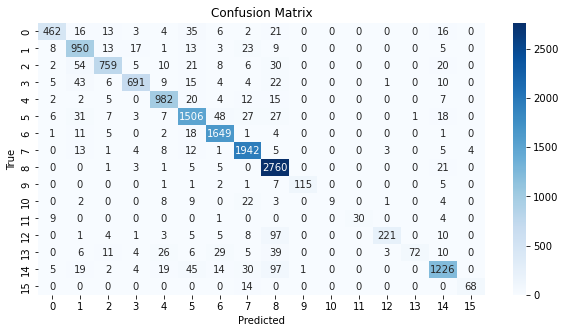

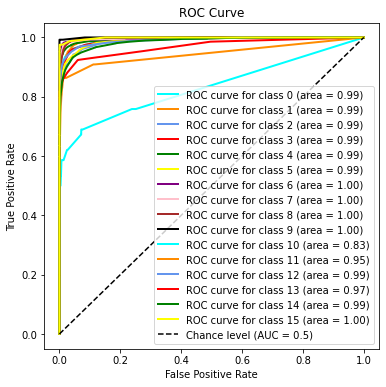

                    precision    recall  f1-score   support

      abcat0100000       0.92      0.80      0.86       578
      abcat0200000       0.83      0.91      0.87      1042
      abcat0207000       0.92      0.83      0.87       915
      abcat0300000       0.94      0.85      0.89       810
      abcat0400000       0.91      0.94      0.92      1049
      abcat0500000       0.88      0.90      0.89      1681
      abcat0700000       0.93      0.97      0.95      1692
      abcat0800000       0.93      0.97      0.95      1998
      abcat0900000       0.88      0.99      0.93      2796
          cat09000       0.99      0.87      0.93       132
pcmcat128500050004       1.00      0.16      0.27        58
pcmcat139900050002       1.00      0.68      0.81        44
pcmcat242800050021       0.97      0.62      0.76       355
pcmcat252700050006       0.99      0.34      0.51       211
pcmcat312300050015       0.90      0.84      0.87      1462
pcmcat332000050000       0.94      0.83

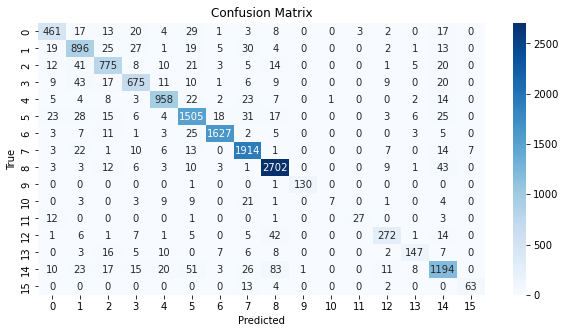

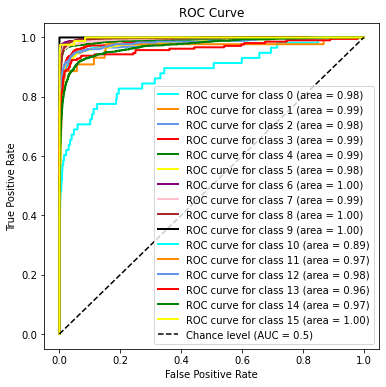

                    precision    recall  f1-score   support

      abcat0100000       0.82      0.80      0.81       578
      abcat0200000       0.82      0.86      0.84      1042
      abcat0207000       0.85      0.85      0.85       915
      abcat0300000       0.86      0.83      0.85       810
      abcat0400000       0.92      0.91      0.92      1049
      abcat0500000       0.87      0.90      0.88      1681
      abcat0700000       0.97      0.96      0.97      1692
      abcat0800000       0.92      0.96      0.94      1998
      abcat0900000       0.93      0.97      0.95      2796
          cat09000       0.99      0.98      0.99       132
pcmcat128500050004       0.88      0.12      0.21        58
pcmcat139900050002       0.90      0.61      0.73        44
pcmcat242800050021       0.85      0.77      0.80       355
pcmcat252700050006       0.84      0.70      0.76       211
pcmcat312300050015       0.86      0.82      0.84      1462
pcmcat332000050000       0.90      0.77

In [4]:
# Combine text columns to form the feature set
X_train = train_df[text_columns].values
X_test = test_df[text_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

#### 3.2.2. Train and Evaluate Image Model

####################  Random Forest  ####################


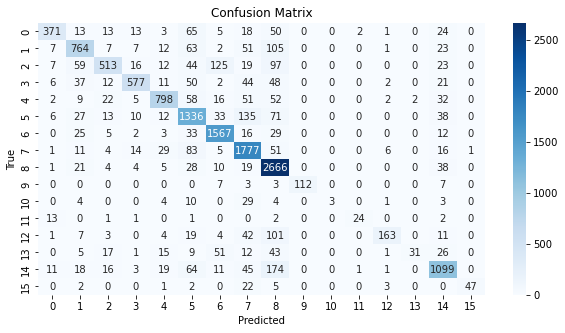

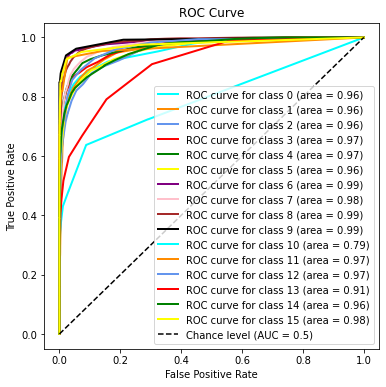

                    precision    recall  f1-score   support

      abcat0100000       0.87      0.64      0.74       578
      abcat0200000       0.76      0.73      0.75      1042
      abcat0207000       0.81      0.56      0.66       915
      abcat0300000       0.88      0.71      0.79       810
      abcat0400000       0.86      0.76      0.81      1049
      abcat0500000       0.72      0.79      0.75      1681
      abcat0700000       0.85      0.93      0.89      1692
      abcat0800000       0.78      0.89      0.83      1998
      abcat0900000       0.76      0.95      0.85      2796
          cat09000       1.00      0.85      0.92       132
pcmcat128500050004       1.00      0.05      0.10        58
pcmcat139900050002       0.89      0.55      0.68        44
pcmcat242800050021       0.90      0.46      0.61       355
pcmcat252700050006       0.94      0.15      0.25       211
pcmcat312300050015       0.80      0.75      0.77      1462
pcmcat332000050000       0.98      0.57

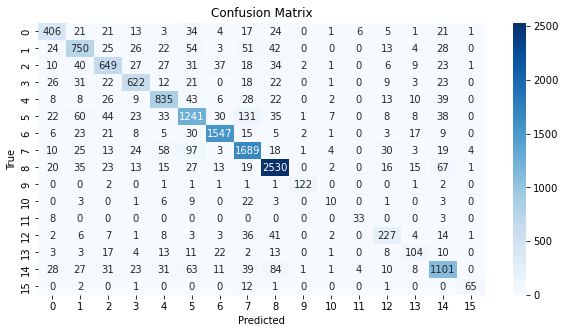

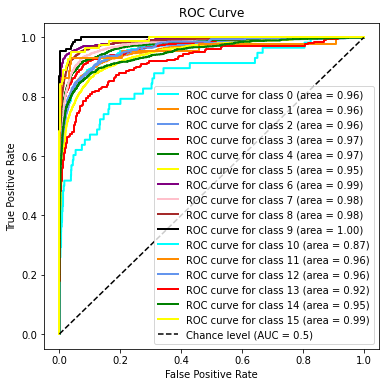

                    precision    recall  f1-score   support

      abcat0100000       0.71      0.70      0.71       578
      abcat0200000       0.73      0.72      0.72      1042
      abcat0207000       0.72      0.71      0.71       915
      abcat0300000       0.78      0.77      0.78       810
      abcat0400000       0.78      0.80      0.79      1049
      abcat0500000       0.75      0.74      0.74      1681
      abcat0700000       0.92      0.91      0.92      1692
      abcat0800000       0.81      0.85      0.82      1998
      abcat0900000       0.88      0.90      0.89      2796
          cat09000       0.95      0.92      0.93       132
pcmcat128500050004       0.30      0.17      0.22        58
pcmcat139900050002       0.77      0.75      0.76        44
pcmcat242800050021       0.65      0.64      0.64       355
pcmcat252700050006       0.56      0.49      0.52       211
pcmcat312300050015       0.79      0.75      0.77      1462
pcmcat332000050000       0.89      0.79

In [5]:
# Combine image columns to form the feature set
X_train = train_df[image_columns].values
X_test = test_df[image_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

#### 3.2.3. Train and Evaluate Combined Model

####################  Random Forest  ####################


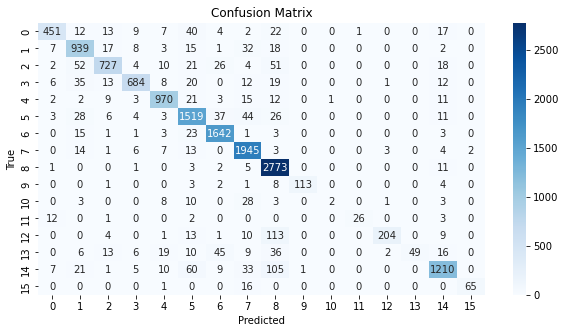

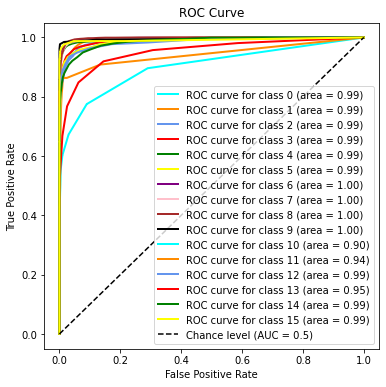

                    precision    recall  f1-score   support

      abcat0100000       0.92      0.78      0.84       578
      abcat0200000       0.83      0.90      0.87      1042
      abcat0207000       0.90      0.79      0.84       915
      abcat0300000       0.94      0.84      0.89       810
      abcat0400000       0.92      0.92      0.92      1049
      abcat0500000       0.86      0.90      0.88      1681
      abcat0700000       0.93      0.97      0.95      1692
      abcat0800000       0.90      0.97      0.94      1998
      abcat0900000       0.87      0.99      0.93      2796
          cat09000       0.99      0.86      0.92       132
pcmcat128500050004       0.67      0.03      0.07        58
pcmcat139900050002       0.96      0.59      0.73        44
pcmcat242800050021       0.97      0.57      0.72       355
pcmcat252700050006       1.00      0.23      0.38       211
pcmcat312300050015       0.91      0.83      0.87      1462
pcmcat332000050000       0.97      0.79

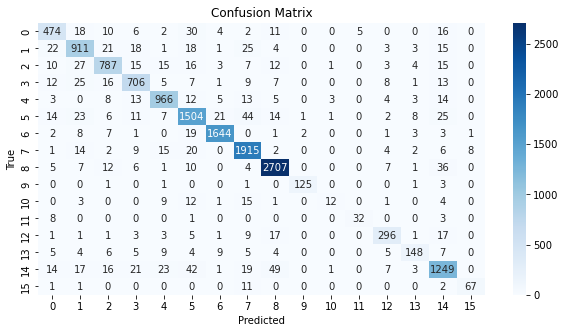

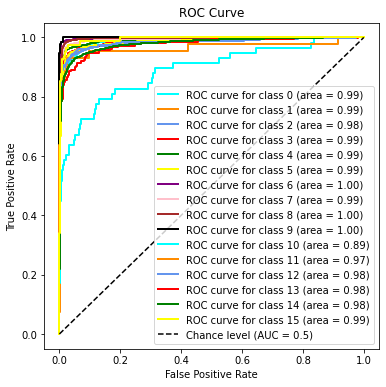

                    precision    recall  f1-score   support

      abcat0100000       0.83      0.82      0.82       578
      abcat0200000       0.86      0.87      0.87      1042
      abcat0207000       0.88      0.86      0.87       915
      abcat0300000       0.87      0.87      0.87       810
      abcat0400000       0.91      0.92      0.92      1049
      abcat0500000       0.88      0.89      0.89      1681
      abcat0700000       0.97      0.97      0.97      1692
      abcat0800000       0.92      0.96      0.94      1998
      abcat0900000       0.96      0.97      0.96      2796
          cat09000       0.98      0.95      0.96       132
pcmcat128500050004       0.67      0.21      0.32        58
pcmcat139900050002       0.86      0.73      0.79        44
pcmcat242800050021       0.87      0.83      0.85       355
pcmcat252700050006       0.83      0.70      0.76       211
pcmcat312300050015       0.87      0.85      0.86      1462
pcmcat332000050000       0.88      0.82

In [6]:
# Combine text and image columns to form the feature set
X_train = train_df[text_columns + image_columns].values
X_test = test_df[text_columns + image_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

### 3.3 Multi-layer Perceptron

*Now it's time to train our first Neural Network model. For simplicity, we are going to try using an MLP model.*

*A Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes.*


#### 3.3.1 Perpare the dataset

In [7]:
# Initialize LabelEncoder and fit it only on the training data
label_encoder = LabelEncoder()
label_encoder.fit(train_df[label_columns])

LabelEncoder()

#### 3.3.2. Train and Evaluate the image model

In [8]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(train_df, text_cols=None, image_cols=image_columns, label_col=label_columns, encoder=label_encoder)
test_dataset = MultimodalDataset(test_df, text_cols=None, image_cols=image_columns, label_col=label_columns, encoder=label_encoder)

text_input_size = None
image_input_size = len(image_columns)
output_size = label_encoder.classes_.shape[0]

Training Image Model:
Metal device set to: 

2024-09-13 17:04:26.710235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-13 17:04:26.711772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-09-13 17:04:27.163600: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-09-13 17:04:27.166910: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2024-09-13 17:04:27.528206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - ETA: 0s - loss: 1.2487 - accuracy: 0.6276

2024-09-13 17:04:49.708580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 26s 24ms/step - loss: 1.2487 - accuracy: 0.6276 - val_loss: 0.9358 - val_accuracy: 0.7245
Epoch 2/50
1086/1086 [==============================] - 26s 23ms/step - loss: 0.8168 - accuracy: 0.7265 - val_loss: 0.8389 - val_accuracy: 0.7507
Epoch 3/50
1086/1086 [==============================] - 26s 24ms/step - loss: 0.6823 - accuracy: 0.7562 - val_loss: 0.7772 - val_accuracy: 0.7708
Epoch 4/50
1086/1086 [==============================] - 26s 24ms/step - loss: 0.5921 - accuracy: 0.7823 - val_loss: 0.7323 - val_accuracy: 0.7897
Epoch 5/50
1086/1086 [==============================] - 27s 25ms/step - loss: 0.5347 - accuracy: 0.7987 - val_loss: 0.7491 - val_accuracy: 0.7854
Epoch 6/50
1086/1086 [==============================] - 27s 25ms/step - loss: 0.4921 - accuracy: 0.8088 - val_loss: 0.7126 - val_accuracy: 0.7949
Epoch 7/50
1086/1086 [==============================] - 26s 24ms/step - loss: 0.4490 - accuracy: 0.8235 - val_loss: 0.6783 - val_accura

2024-09-13 17:13:21.832633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


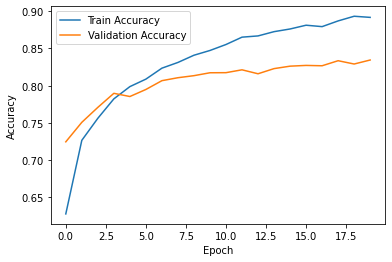

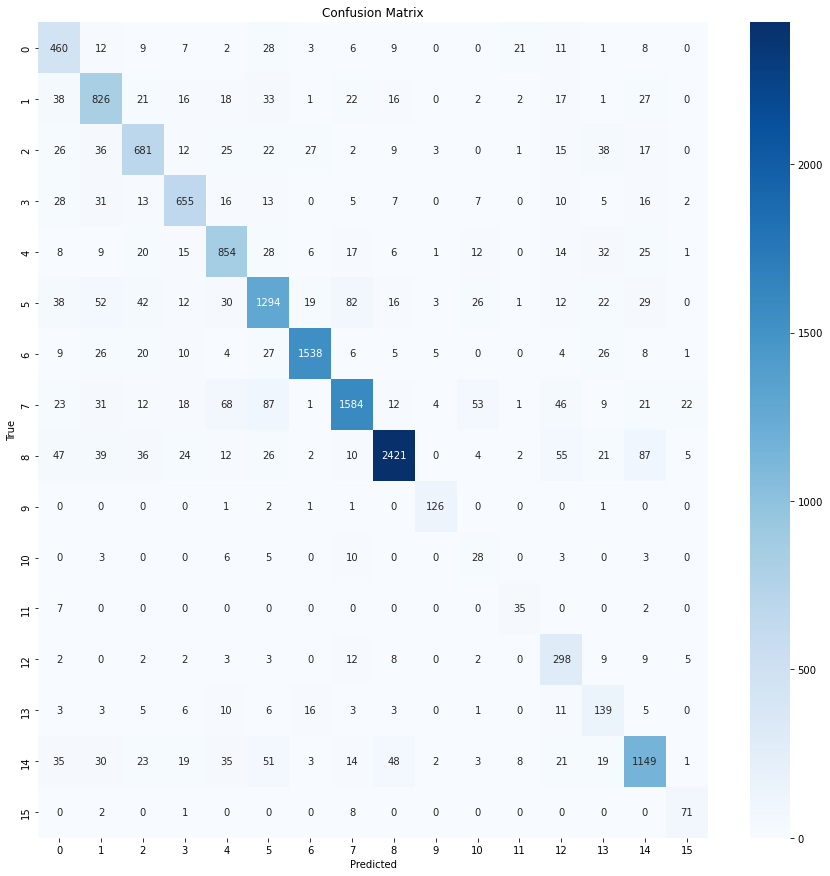

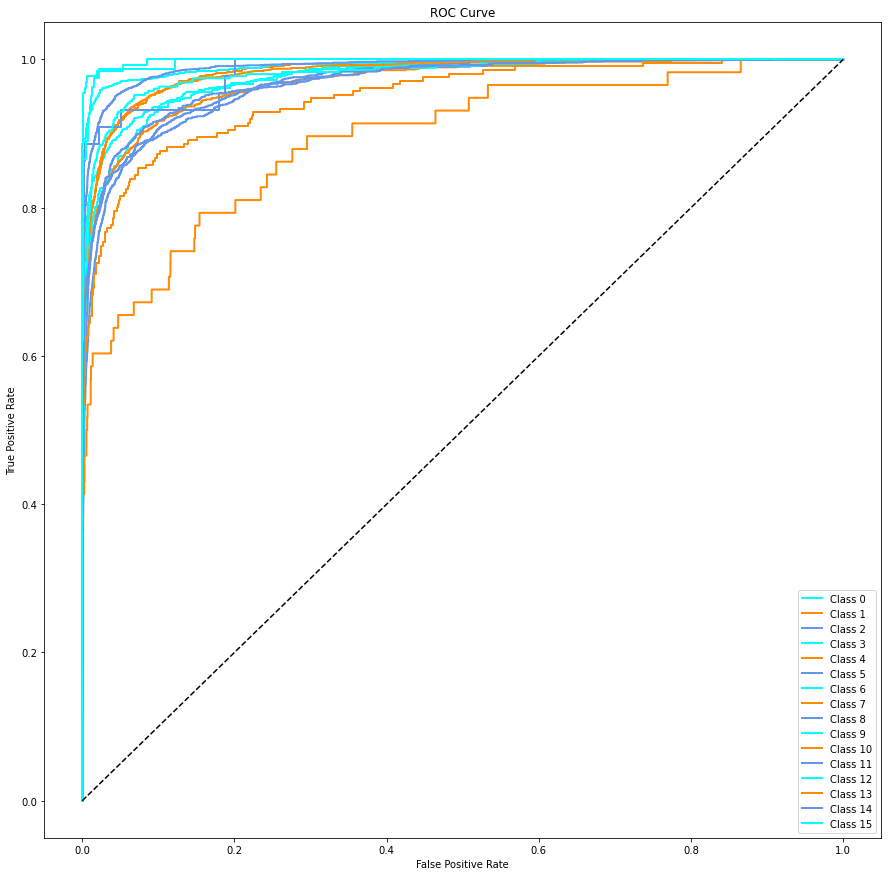

                    precision    recall  f1-score   support

      abcat0100000       0.64      0.80      0.71       577
      abcat0200000       0.75      0.79      0.77      1040
      abcat0207000       0.77      0.75      0.76       914
      abcat0300000       0.82      0.81      0.82       808
      abcat0400000       0.79      0.81      0.80      1048
      abcat0500000       0.80      0.77      0.78      1678
      abcat0700000       0.95      0.91      0.93      1689
      abcat0800000       0.89      0.80      0.84      1992
      abcat0900000       0.95      0.87      0.90      2791
          cat09000       0.88      0.95      0.91       132
pcmcat128500050004       0.20      0.48      0.29        58
pcmcat139900050002       0.49      0.80      0.61        44
pcmcat242800050021       0.58      0.84      0.68       355
pcmcat252700050006       0.43      0.66      0.52       211
pcmcat312300050015       0.82      0.79      0.80      1461
pcmcat332000050000       0.66      0.87

(<tensorflow.python.keras.engine.functional.Functional at 0x335db8d30>,
 0.8171370967741935,
 0.7420407075900071,
 0.9738458193295765)

In [9]:
# Train the model
print("Training Image Model:")
train_mlp(train_dataset, test_dataset,
            text_input_size=text_input_size, 
            image_input_size=image_input_size, 
            output_size=output_size, 
            num_epochs=50,
            report=True, 
            lr=0.001, 
            set_weights=True, 
            adam=True, 
            p=0.2,  
            seed=42, 
            patience=10)

#### 3.3.3. Train and Evaluate the text model

In [10]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(train_df, text_cols=text_columns, image_cols=None, label_col=label_columns, encoder=label_encoder)
test_dataset = MultimodalDataset(test_df, text_cols=text_columns, image_cols=None, label_col=label_columns, encoder=label_encoder)

text_input_size = len(text_columns)
image_input_size = None
output_size = label_encoder.classes_.shape[0]

Training Text Model:
Epoch 1/50


2024-09-13 17:13:32.249882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1085/1086 [============================>.] - ETA: 0s - loss: 0.9214 - accuracy: 0.7348

2024-09-13 17:13:54.826158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 27s 24ms/step - loss: 0.9209 - accuracy: 0.7350 - val_loss: 0.5369 - val_accuracy: 0.8538
Epoch 2/50
1086/1086 [==============================] - 25s 23ms/step - loss: 0.5540 - accuracy: 0.8400 - val_loss: 0.4894 - val_accuracy: 0.8646
Epoch 3/50
1086/1086 [==============================] - 27s 25ms/step - loss: 0.4437 - accuracy: 0.8626 - val_loss: 0.4251 - val_accuracy: 0.8836
Epoch 4/50
1086/1086 [==============================] - 25s 23ms/step - loss: 0.3935 - accuracy: 0.8762 - val_loss: 0.4164 - val_accuracy: 0.8881
Epoch 5/50
1086/1086 [==============================] - 26s 24ms/step - loss: 0.3465 - accuracy: 0.8890 - val_loss: 0.3716 - val_accuracy: 0.8983
Epoch 6/50
1086/1086 [==============================] - 26s 24ms/step - loss: 0.3034 - accuracy: 0.8989 - val_loss: 0.3789 - val_accuracy: 0.9011
Epoch 7/50
1086/1086 [==============================] - 25s 23ms/step - loss: 0.2960 - accuracy: 0.9017 - val_loss: 0.3677 - val_accura

2024-09-13 17:27:57.638201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


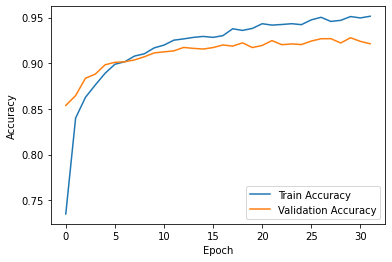

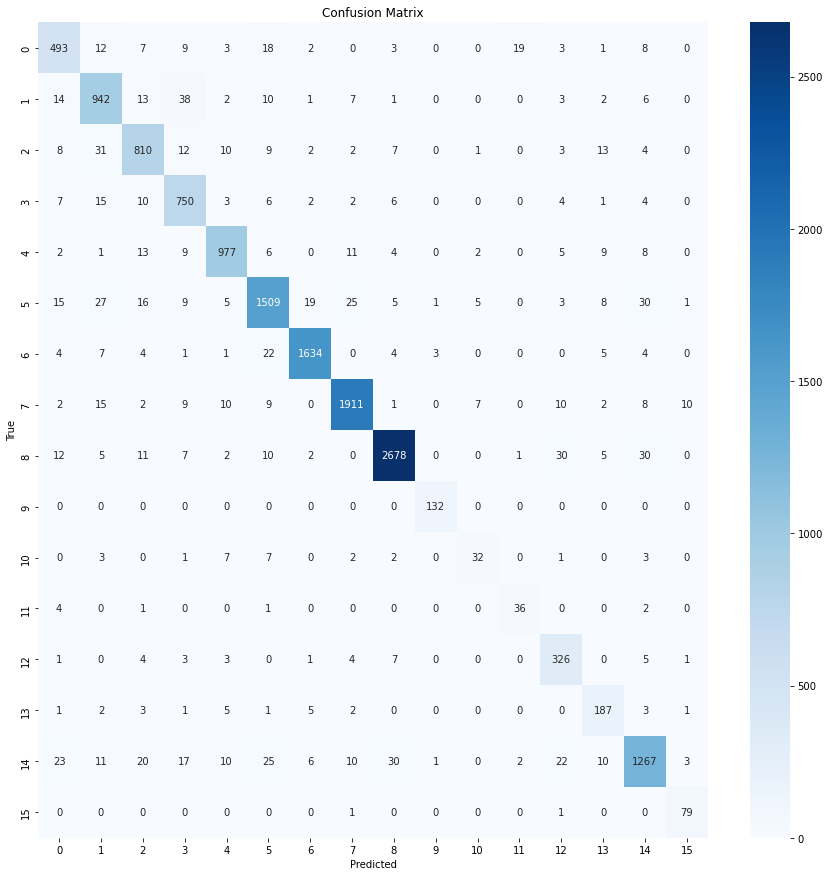

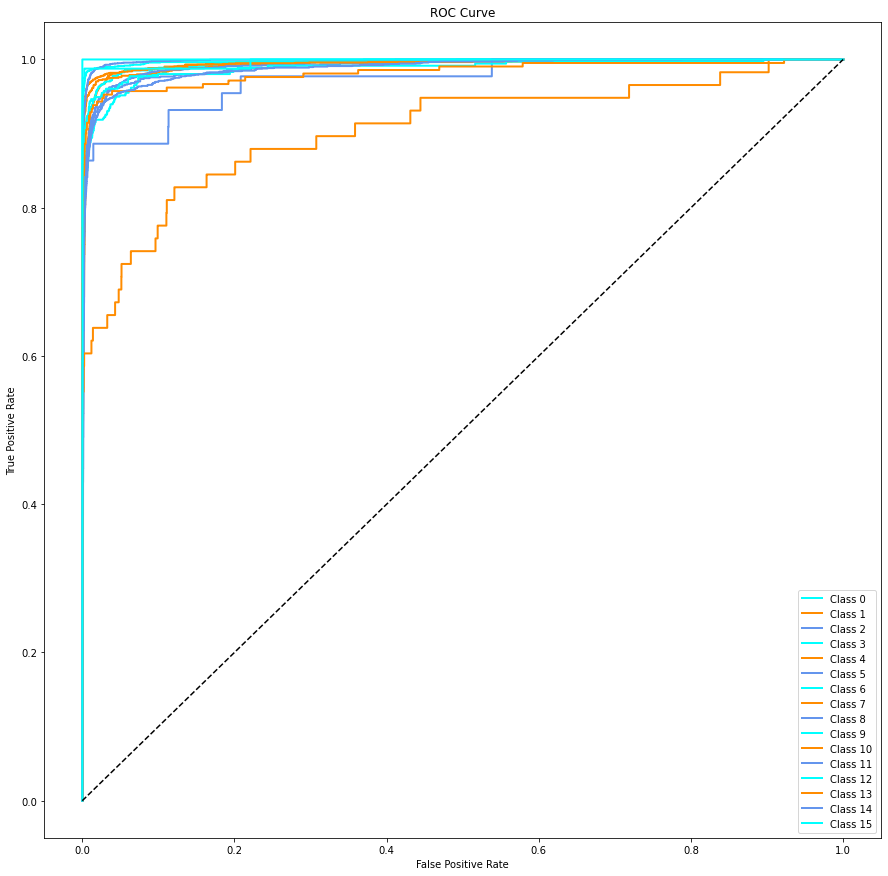

                    precision    recall  f1-score   support

      abcat0100000       0.84      0.85      0.85       578
      abcat0200000       0.88      0.91      0.89      1039
      abcat0207000       0.89      0.89      0.89       912
      abcat0300000       0.87      0.93      0.89       810
      abcat0400000       0.94      0.93      0.94      1047
      abcat0500000       0.92      0.90      0.91      1678
      abcat0700000       0.98      0.97      0.97      1689
      abcat0800000       0.97      0.96      0.96      1996
      abcat0900000       0.97      0.96      0.97      2793
          cat09000       0.96      1.00      0.98       132
pcmcat128500050004       0.68      0.55      0.61        58
pcmcat139900050002       0.62      0.82      0.71        44
pcmcat242800050021       0.79      0.92      0.85       355
pcmcat252700050006       0.77      0.89      0.82       211
pcmcat312300050015       0.92      0.87      0.89      1457
pcmcat332000050000       0.83      0.98

(<tensorflow.python.keras.engine.functional.Functional at 0x34d6927c0>,
 0.9249327956989247,
 0.8770784574686039,
 0.9865016321030795)

In [11]:
# Train the model
print("Training Text Model:")
train_mlp(train_dataset, test_dataset,
            text_input_size=text_input_size, 
            image_input_size=image_input_size, 
            output_size=output_size, 
            num_epochs=50,
            report=True, 
            lr=0.001, 
            set_weights=True, 
            adam=True, 
            p=0.2,  
            seed=42, 
            patience=10)

#### 3.3.4. Train and Evaluate the fusion model

In [12]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(train_df, text_cols=text_columns, image_cols=image_columns, label_col=label_columns, encoder=label_encoder)
test_dataset = MultimodalDataset(test_df, text_cols=text_columns, image_cols=image_columns, label_col=label_columns, encoder=label_encoder)

text_input_size = len(text_columns)
image_input_size = len(image_columns)
output_size = label_encoder.classes_.shape[0]

Training Early Fusion Model:
Epoch 1/50


2024-09-13 17:28:09.651935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1084/1086 [============================>.] - ETA: 0s - loss: 0.9750 - accuracy: 0.7173

2024-09-13 17:28:33.874369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1086/1086 [==============================] - 28s 26ms/step - loss: 0.9743 - accuracy: 0.7174 - val_loss: 0.6121 - val_accuracy: 0.8212
Epoch 2/50
1086/1086 [==============================] - 28s 26ms/step - loss: 0.4950 - accuracy: 0.8408 - val_loss: 0.4732 - val_accuracy: 0.8693
Epoch 3/50
1086/1086 [==============================] - 34s 31ms/step - loss: 0.3803 - accuracy: 0.8728 - val_loss: 0.4528 - val_accuracy: 0.8706
Epoch 4/50
1086/1086 [==============================] - 29s 26ms/step - loss: 0.2960 - accuracy: 0.8950 - val_loss: 0.3851 - val_accuracy: 0.8950
Epoch 5/50
1086/1086 [==============================] - 28s 25ms/step - loss: 0.2664 - accuracy: 0.9047 - val_loss: 0.3720 - val_accuracy: 0.8946
Epoch 6/50
1086/1086 [==============================] - 28s 26ms/step - loss: 0.2429 - accuracy: 0.9108 - val_loss: 0.3347 - val_accuracy: 0.9079
Epoch 7/50
1086/1086 [==============================] - 28s 26ms/step - loss: 0.2034 - accuracy: 0.9223 - val_loss: 0.3583 - val_accura

2024-09-13 17:40:05.745123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


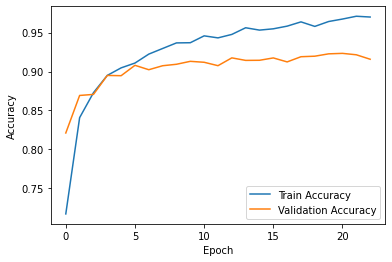

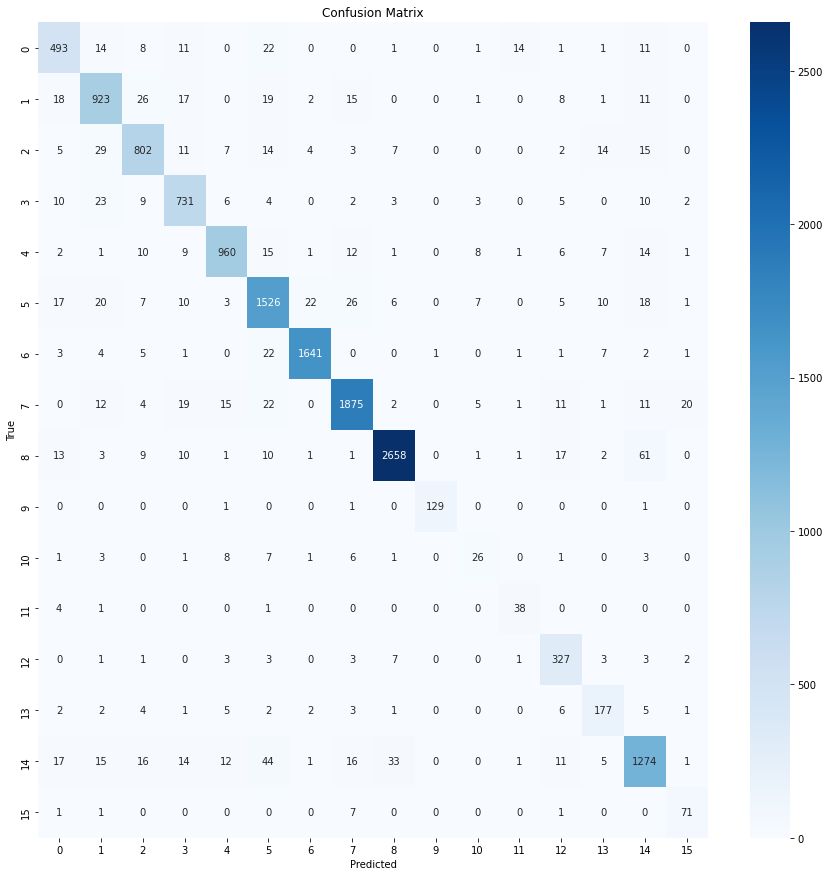

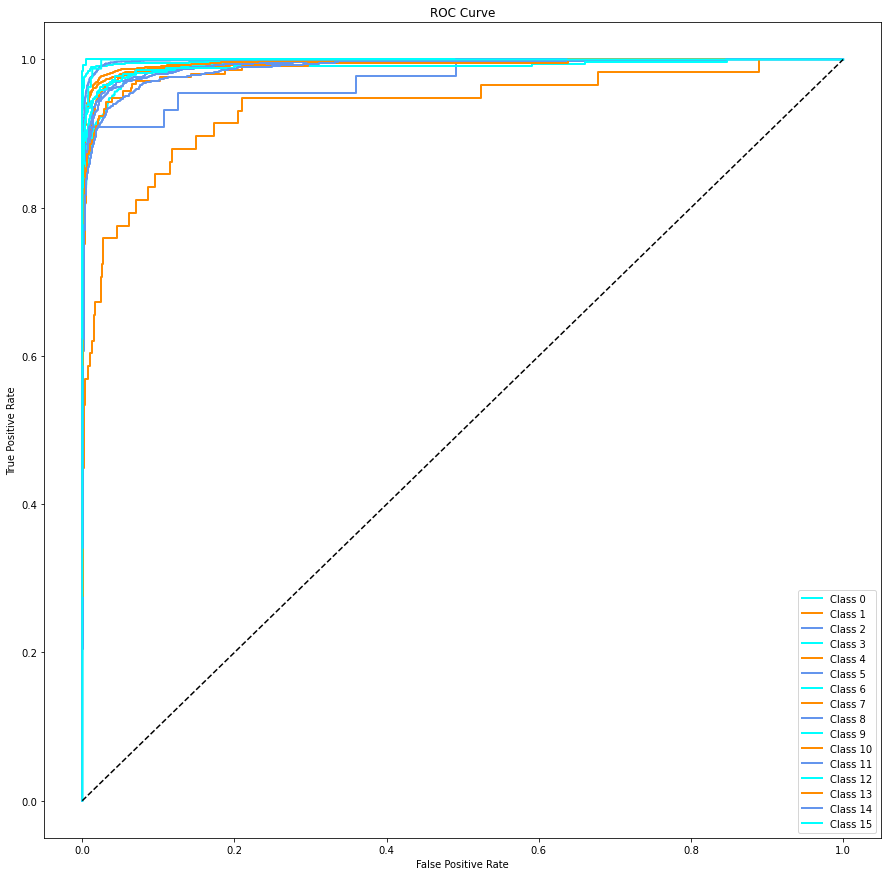

                    precision    recall  f1-score   support

      abcat0100000       0.84      0.85      0.85       577
      abcat0200000       0.88      0.89      0.88      1041
      abcat0207000       0.89      0.88      0.88       913
      abcat0300000       0.88      0.90      0.89       808
      abcat0400000       0.94      0.92      0.93      1048
      abcat0500000       0.89      0.91      0.90      1678
      abcat0700000       0.98      0.97      0.98      1689
      abcat0800000       0.95      0.94      0.95      1998
      abcat0900000       0.98      0.95      0.97      2788
          cat09000       0.99      0.98      0.98       132
pcmcat128500050004       0.50      0.45      0.47        58
pcmcat139900050002       0.66      0.86      0.75        44
pcmcat242800050021       0.81      0.92      0.87       354
pcmcat252700050006       0.78      0.84      0.81       211
pcmcat312300050015       0.89      0.87      0.88      1460
pcmcat332000050000       0.71      0.88

(<tensorflow.python.keras.engine.functional.Functional at 0x3447db670>,
 0.9174059139784946,
 0.8597316054593414,
 0.9895182327699723)

In [13]:
# Train the model
print("Training Early Fusion Model:")
train_mlp(train_dataset, test_dataset,
            text_input_size=text_input_size, 
            image_input_size=image_input_size, 
            output_size=output_size, 
            num_epochs=50,
            report=True, 
            lr=0.001, 
            set_weights=True, 
            adam=True, 
            p=0.2,  
            seed=42, 
            patience=10)

Take into account that the model trained will be evaluated in multiple classes. It's important to use the right loss function and metrics for this task. 

Check the perfermance of the model in each class. Is the model overfitting? Underfitting? What can you do to improve the model?

Aditionally, the fusion model is performing better than the individual models? Why?

## 7. Optional. Make your own model

The models we've trained before are just a limited set over the universe of stuff you can use. 

You still have a lot of things to experiment with to increase accuracy, some ideas are:

1. Use other pre-trained models for text and image embeddings.
2. Use closed-source models like OpenAI's models from the API.
2. Try adding data augmentation or any other regularization algorithms.
4. Check [KerasTuner](https://keras.io/api/keras_tuner/) documentation about how to efficiently test a lot of different architectures and parameters.
5. Is there a trade-off between the different models in terms of performance and computational cost? How would you decide which model to use in a production environment?